### Names:
* Idan Tal - <br>
ID: 205817737<br>
Mail: idant14@gmail.com<br>
* Tal Leibovich - <br>
ID: 203716642<br>
Mail: talmm11@gmail.com<br>

### Objective
<b>What is Kiva?</b><br>
Kiva is a platform for borrowing money for any personal matter, and is especially active in 3rd world contries.
<br><br>
<b>Our goal</b><br>
Helping Kiva to predict how likely a loan is to be funded. We will be using a labeled dataset (our ground truth mechanism is described below under the "labeling" sub section). Since the data for each borrower is limited, we will be using external datasets (such as the "MPI" dataset) to better understand his/her financial background and to help lenders and Kiva invest wisely.


### Motivation
Kiva is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. Kiva lenders have provided over $1 billion dollars in loans to over 2 million people. In order to set investment priorities, help inform lenders, and understand their target communities, knowing the level of poverty of each borrower is critical. However, this requires inference based on a limited set of information for each borrower.

### Data
1. We decided to go on with [this challenge](https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding) due to its publish on kaggle.com
2. The [MPI datasets](https://www.kaggle.com/ophi/mpi) are also available through Kaggle.
3. The available geographical data for each loan is not always consistent. The region column somtimes describe a city instead of a region, while the MPI keeps using regions. We will be using other datasets to convert the Kiva available data more suitable to be used against the MPI and other welfare indices. Other external examples we consider: Wikipedia, Google Maps API, etc.

### Tools
Pandas, sklearn (SGDRegressor, SGDClassifier), matplotlib, other clustering tools.

In [2]:
import pandas as pd
import numpy as np
import math
import nltk
# Download if isn't installed
#nltk.download()
from nltk.tokenize import RegexpTokenizer

print("loading...")
loans = pd.read_csv(r"datasets/kiva_loans.csv")
mpi_region = pd.read_csv(r"datasets/MPI_subnational.csv")
mpi_country = pd.read_csv(r"datasets/MPI_national.csv")
print("loaded.")

loading...
loaded.


# Learning the data
Before running any complex algorithm, we should learn how complete and accurate our data is.

## Tags
The Tags column isn't very useful for data science purposes the way it is presented right now.
This section adds tags as independent columns. It takes a while to compute, if we'd like to use tags as meaningful data we should create a new CSV with these columns

In [3]:
stags = set()
for tags in loans.tags:
    if type(tags) != str:
        continue
    tags = tags.split(",")
    for tag in tags:
        tag = tag.strip("# '")
        stags.add(tag)
        
print(stags)


{'Sustainable Ag', 'Trees', 'Elderly', 'Repeat Borrower', 'Fabrics', 'Animals', 'Refugee', 'Interesting Photo', 'Job Creator', 'Technology', 'First Loan', 'Widowed', 'Hidden Gem', 'Repair Renew Replace', 'Schooling', 'Post-disbursed', 'Low-profit FP', 'Female Education', 'Eco-friendly', 'Single', 'Unique', 'volunteer_like', 'Parent', 'Orphan', 'Health and Sanitation', 'Woman Owned Biz', 'Inspiring Story', 'user_like', 'user_favorite', 'Biz Durable Asset', 'Tourism', 'Single Parent', 'volunteer_pick', 'Supporting Family', 'Vegan'}


### Extracting features from the tags field
TODO: tags - this data might be interesting, it should be analyzed and we might resolve more features out of it.



### Extraction features from the description field
We might be using here some NLP techniques to obtain more interesting features from the from free text fields.

## Loans uses

In [4]:
stop_words = set(nltk.corpus.stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')
final = []
for use in loans.use:
    if type(use) != str:
        continue
    tokenized = tokenizer.tokenize(use)
    filtered = [w.lower() for w in tokenized if w not in stop_words]
    final.extend(filtered)
#     final += " " + " ".join(filtered)
final = " ".join(final)

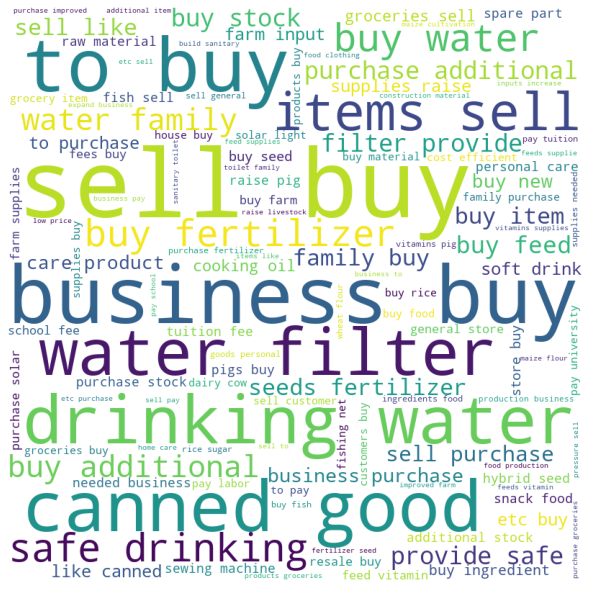

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(final)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Missing Data (Preprocessing)

Before dwelving into the dataset, lets check how complete the dataset is.

#### Kiva's Loans rows

In [6]:
missing_data_in_rows = dict()
for key in loans.keys():
    data = loans[key]
    count = 0
    for line in data:
        if not line or (type(line) == float and math.isnan(line)):
            count += 1
    missing_data_in_rows[key] = count / (len(loans) * 1.0)
    print(f'{key}: {count/len(loans)*100}% ({count}/{len(loans)})')# ({missing_data_in_rows[key]}/{count})')

    #TODO: visualize the numbers

id: 0.0% (0/671205)
funded_amount: 0.5040188913968162% (3383/671205)
loan_amount: 0.0% (0/671205)
activity: 0.0% (0/671205)
sector: 0.0% (0/671205)
use: 0.6305078180287691% (4232/671205)
country_code: 0.0011918862344589209% (8/671205)
country: 0.0% (0/671205)
region: 8.46239226465834% (56800/671205)
currency: 0.0% (0/671205)
partner_id: 2.0123509211045807% (13507/671205)
posted_time: 0.0% (0/671205)
disbursed_time: 0.3569699272204468% (2396/671205)
funded_time: 7.200631699704263% (48331/671205)
term_in_months: 0.0% (0/671205)
lender_count: 0.5040188913968162% (3383/671205)
tags: 25.5385463457513% (171416/671205)
borrower_genders: 0.6288689744563881% (4221/671205)
repayment_interval: 0.0% (0/671205)
date: 0.0% (0/671205)


In [7]:

# Note that 7% in funded_time is not really missing, as it only indicates loans which were not fully funded.


## Labeling
Our training set will be labeled with "succes" or "failure", based on if the borrower successfully managed to fund his loan in Kiva. The label will be based on the following condition:<br>
loan_amount - funded_amount == 0
<br><br>
The first issue which is raised is how to balance to data, since most of the loans were successfully funded. Methods we are considering: 
1. <b>oversampling</b> - duplication of existing data in order to enlarge the data set size.
2. <b>reducing the succes samples</b> - we don't have enough unseccessful loans data, one approach which can be taken is to just not use all the successful loans data.
3. <b>using imbalance datasets</b> - doesn't seem to be promising, but we're also considering using more successful loans data than unsuccessful.

# Fixing the data (Preprocessing)

## Regional MPI
Not all the region on the loans dataset can be found on the regional MPI, meaning we are not given region but something else. after a quick google search, the region data we are given are cities instead of region.
If we had MPI info for cities it could've been great, but we'll have to "zoom out" and figure in which region those cities are located. We currently have 12674 unique cities (slightly less, taking into account 'nan' entries.)

In [8]:
missing = set()
for region in loans.region.unique(): #what if there are 2 different regions from different countries but with the same name?
    if region not in mpi_region['Sub-national region'].values:
        missing.add(region)
print(f"Amount of missing regions: {len(missing)}")

Amount of missing regions: 12565


Translating city to region won't be an easy job, considering all the different countries. An easier approach would be fixing the larger chunk of data, doing the least job. So we'll find out how many entries we have for each country.

In [9]:
loans_geo_df = loans.groupby(['country','region']).size().reset_index(name='Freq')
loans_geo_country_df = loans.groupby(['country']).size().reset_index(name='Freq')

mpi_df = mpi_region[['Country', 'Sub-national region']] 
mpi_df = mpi_df.rename(columns={'Country': 'country', 'Sub-national region': 'region'})
loans_geo_with_mpi_df = loans_geo_df.merge(mpi_df, indicator=True, how='outer', on=(['country', 'region']))
loans_geo_country_with_mpi_df = loans_geo_with_mpi_df.groupby(['country']).sum().sort_values('Freq', ascending=False)

missing_regions = int(loans_geo_with_mpi_df[loans_geo_with_mpi_df['_merge'] == 'left_only']['Freq'].sum())
missing_regions_top10 = int(loans_geo_country_with_mpi_df[:10].sum()['Freq'])

print(f"Amount of loans with missing regions: {missing_regions}")
print(f"Only in the top 10: {missing_regions_top10}")
print(f"{missing_regions_top10/missing_regions*100}%\n")
print(loans_geo_country_with_mpi_df[:10])

Amount of loans with missing regions: 563450
Only in the top 10: 405367
71.94373946224155%

                 Freq
country              
Philippines  160360.0
Kenya         67073.0
Cambodia      34811.0
Pakistan      26852.0
Peru          22073.0
Colombia      21218.0
Uganda        20390.0
El Salvador   19624.0
Tajikistan    19482.0
Ecuador       13484.0


We have total of 671205 loan entries. 563450 of them has a corrupted region info. Fixing the top 10 countries on that list would fix 72% of that list. We can fix those and use the national MPI for the rest of the corrupted entries. Our data will be less acurate, but we can either focus on the top 10 countries or use the less accurate data. (we will still have enough data only from the 10 top)

## Fixing regions data

In [10]:
#TODO: the most prominent regions have to be fixed by the external MPI dataset. Philippines is shown here as an example.

### Fixing Philippines Region

In [11]:
from nltk.tokenize import word_tokenize 
from difflib import SequenceMatcher
ph_regions = pd.read_csv(r"datasets/ph_regions.csv")
ph_provinces = pd.read_csv(r"datasets/ph_provinces.csv")
ph_provinces.Province = ph_provinces.Province.str.lower()
def fix_ph_region(region):
    if type(region) != str:
        return None
    region_code = None
    region_info = region.split(",")
    for i in region_info:
        i = i.strip().lower()
        entries = ph_provinces.query('Province == @i')
        if len(entries):
            if len(entries) != 1:
                raise
            region_code = entries.Region.iloc[0]
            break
        entries = []
        similar = (0, "")
        for prov in ph_provinces.Province:
            sim_ratio = SequenceMatcher(None, i, prov).ratio()
            if sim_ratio > similar[0]:
                similar = (sim_ratio, prov)
        if similar[0] > 0.85:
            s = ph_provinces.query("Province == @similar[1]")
            if len(s) != 1:
                raise
            region_code = s.Region.iloc[0]
            break
    if region_code is not None:
        entries = ph_regions.query("`Region code` == @region_code")
        retval =  entries.iloc[0, entries.columns.get_loc('Region')]
        return retval
    return None

In [12]:
count = 0
mi = set()

# TODO: Fix the code. Missing region is DataFrame object
for region in missing_regions:
    if region[0] == "Philippines":
        if type(region[1]) != str:
            continue
        found = fix_ph_region(region[1]) is not None
        if not found:
            count += 1
            mi.add(region[1])
# The other results contain city names and not regions / provinces
print(count)

# Find how many entries we actually solved for loans
m = dict()
t = list()
for region in missing_regions:
    if region[0] == "Philippines":
        t.append(missing_regions[region])
        if region[1] in mi:
            m[region[1]] = missing_regions[region]
print(sum(m.values()), sum(t))
c1 = 0
for i in sorted(m, key=m.get):
    if (m[i]) > 100:
        c1 += 1
        print(i)
print("More than 100:", c1)
# print(mi)
sum([m[i] for i in sorted(m, key=m.get)[:-c1:-1]])



TypeError: 'int' object is not iterable

Originally we had 12k unique unresolved entries,  and we've reduced the unique unresolved to 1217.<br>
Total unresolved loan entries were reduced from 160k to 18623. <br>
We can resolve 24 cities manually and reduce it from 18623 to 7990, but for now 89% of the data would be enough
#### Using The Data
We will probably use SGD Regressor or SGD Classifier, Depends on our final goal.  <br>
In case of simply determining how likely a project is likely to be fully donated - we'll use the SGD Classifier <br>
In case of predicting how long it'll take to fund the project - We'll use the SGD regressor. <br>

##### Our data:
Kiva loans <br>
MPI <br>
Additinal city to region indexes, to utilize MPI properly. Some will be created manually.

# Feature extraction

We will take fields from different columns and generate features from them. Some examples:
1. Tags - some interesting tags can produce a boolean feature (exists or not)
2. "is_funded" (boolean) - loan_amount - funded_amount == 0

# Model Creation
We are still reading about the different models which can be learnt.<br>
We try to predict how successful the model finds a given loan.<br>
SGDRegressor might be a good fit.

In [42]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
# TODO: Predict how likely a loan is to succeed using Data Science tools.

In order to test our dataset, we'll be using the Country MPI data, and later on we will use Region MPI data for a more accurate estimate. <br>
We will classify the loans into 2 categories - 
1. Successful - A loan which has been fully funded by Kiva lender,
2. Unsuccessful - A partialy funded loan.

<br>
In the Future we will quantify how successful a loan was based on fund time and fund/loan ratio.

In [43]:
unsuccessful_loans_df = loans[loans['funded_amount'] < loans['loan_amount']]
successful_loans_df = loans[loans['funded_amount'] == loans['loan_amount']]

In [44]:
unsuccessful_with_mpi_df = pd.merge(unsuccessful_loans_df, mpi_country, right_on='Country', left_on='country')
successful_with_mpi_df = pd.merge(successful_loans_df, mpi_country, right_on='Country', left_on='country')

In [45]:
#successful_with_mpi_df.loc[:, ['loan_amount', 'sector', 'activity', 'term_in_months', 'borrower_genders', 'repayment_interval', 'MPI Urban', 'Headcount Ratio Urban', 'Intensity of Deprivation Urban', 'MPI Rural', 'Headcount Ratio Rural', 'Intensity of Deprivation Rural']]

In [46]:
sector_le = LabelEncoder()
activity_le = LabelEncoder()
pay_int_le = LabelEncoder()

In [47]:
undf = unsuccessful_with_mpi_df.loc[:, ['loan_amount', 'sector', 'activity', 'term_in_months', 'repayment_interval', 'MPI Urban', 'Headcount Ratio Urban', 'Intensity of Deprivation Urban', 'MPI Rural', 'Headcount Ratio Rural',
       'Intensity of Deprivation Rural']]
sector_le.fit(undf['sector'].unique())
activity_le.fit(undf['activity'].unique())
pay_int_le.fit(undf['repayment_interval'])
undf['sector'] = sector_le.transform(undf['sector'])
undf['activity'] = activity_le.transform(undf['activity'])
undf['repayment_interval'] = pay_int_le.transform(undf['repayment_interval'])

In [48]:
sudf = successful_with_mpi_df.loc[:, ['loan_amount', 'sector', 'activity', 'term_in_months', 'repayment_interval', 'MPI Urban', 'Headcount Ratio Urban', 'Intensity of Deprivation Urban', 'MPI Rural', 'Headcount Ratio Rural',
       'Intensity of Deprivation Rural']]
sector_le.fit(sudf['sector'].unique())
activity_le.fit(sudf['activity'].unique())
pay_int_le.fit(sudf['repayment_interval'])
sudf['sector'] = sector_le.transform(sudf['sector'])
sudf['activity'] = activity_le.transform(sudf['activity'])
sudf['repayment_interval'] = pay_int_le.transform(sudf['repayment_interval'])

In [49]:
sudf

,loan_amount,sector,activity,term_in_months,repayment_interval,MPI Urban,Headcount Ratio Urban,Intensity of Deprivation Urban,MPI Rural,Headcount Ratio Rural,Intensity of Deprivation Rural
0,300.0,6,67,12.0,1,0.087,20.0,43.3,0.299,55.70,53.6
1,575.0,13,134,11.0,1,0.087,20.0,43.3,0.299,55.70,53.6
2,200.0,1,52,11.0,1,0.087,20.0,43.3,0.299,55.70,53.6
3,400.0,6,95,14.0,2,0.087,20.0,43.3,0.299,55.70,53.6
4,400.0,12,10,14.0,2,0.087,20.0,43.3,0.299,55.70,53.6
...,...,...,...,...,...,...,...,...,...,...,...
550555,750.0,10,79,12.0,2,0.044,11.0,39.8,0.179,40.43,44.3
550556,1050.0,10,79,12.0,2,0.044,11.0,39.8,0.179,40.43,44.3
550557,1150.0,10,79,12.0,2,0.044,11.0,39.8,0.179,40.43,44.3
550558,625.0,10,79,12.0,2,0.044,11.0,39.8,0.179,40.43,44.3


In [50]:
# randomize sudf since we will not be taking all the data
# randomize undf to avoid biases in training/test sets
sudf = sudf.sample(frac=1).reset_index(drop=True)
undf = undf.sample(frac=1).reset_index(drop=True)
print(f'length of total successful loans: {len(sudf)}')
print(f'length of total unsuccessful loans: {len(undf)}')

length of total successful loans: 550560
length of total unsuccessful loans: 39878


In [51]:
# take only 2/3 of the data for training (based on undf size, since undf is 39,878 and sudf is 550,560)
count = int(len(undf) * 2 / 3)
print(f'size of training set (successful and unsuccessful): {count*2}')
Y = []
Y.extend(np.zeros(count)) # for unsuccessful loans - undf
Y.extend(np.ones(count)) # for successful loans - sudf
Y = np.array(Y)
X = pd.concat([undf[:count], sudf[:count]], ignore_index=True)

size of training set (successful and unsuccessful): 53170


In [52]:
classifier = SGDClassifier(max_iter=1000, tol=1e-3)
clf = make_pipeline(StandardScaler(),classifier)

In [53]:
clf.fit(X, Y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

size of test set (successful and unsuccessful): 26585
[[0.72594599 0.27405401]
 [0.32265102 0.67734898]]


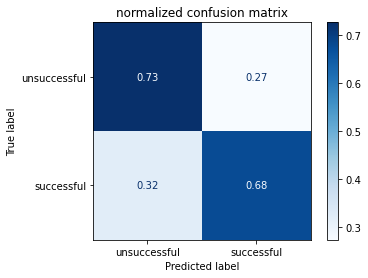

In [54]:
from sklearn.metrics import plot_confusion_matrix

# predict test set - 1/3 of the undf data, or 1/2 of the training set
end_test_set_count = int(3*count/2) + 1
print(f'size of test set (successful and unsuccessful): {count}')
#predict_unsuc = np.array(clf.predict(undf[count:]))
#predict_suc = np.array(clf.predict(undf[count:end_test_set_count]))

X_test = pd.concat([undf[count:], sudf[count:end_test_set_count]], ignore_index=True).reset_index(drop=True)
#X_test = np.concatenate((predict_unsuc, predict_suc))
y_test = np.concatenate((np.zeros(int(count/2)+1), np.ones(int(count/2)+1)))

disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)


# Results
We trained a very first model as a POC. The initial results indicate that there is a case for the current classification problem. We didn't optimize or improve anything - we just used an SGDClassifier out of the box, and of course we're expecting to much better results with further work on that.

# Action Items
1. The data we used so far for training the initial model was not cleaned or preparted enough. We will be adding some more features, and clean/fix the existing (such as regional data from MPI).
2. We trained only one model - SGDClassifier. We'd like to try training different types of models (DNN, other logistic models, etc.).